In [66]:
import numpy as np
from functools import partial
import PIL.Image
import tensorflow as tf
import urllib.request
import os
import zipfile
from io import BytesIO
from IPython.display import Image
#import cv2

In [58]:
# download inception
# create tf session
# pick a layer to enhance our image
# apply graident ascent to that layer
# output deep dreamed image

In [79]:
def main():
    #step 1 - download google's pre-trained neural network
    url = 'https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'
    data_dir = '../data'
    model_name = os.path.split(url)[-1]
    local_zip_file = os.path.join(data_dir, model_name)
    img_noise = np.random.uniform(size=(224,224,3)) + 100.0
    #print(str(local_zip_file))
    #print(str(model_name))
    if not os.path.exists(local_zip_file):
        #download
        model_url = urllib.request.urlopen(url)
        #print(str(model_url))
        with open(local_zip_file, 'wb') as output:
            output.write(model_url.read())
            
        # extract
        with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)


    model_fn = 'tensorflow_inception_graph.pb'
    
    #step 2 - creating Tensorflow session and loading the model
    graph = tf.Graph()
    sess = tf.InteractiveSession(graph=graph)
    with tf.gfile.FastGFile(os.path.join(data_dir, model_fn), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    t_input = tf.placeholder(np.float32, name='input') #define input tensor
    imagenet_mean = 117.0
    t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
    tf.import_graph_def(graph_def, {'input':t_preprocessed})
    
    def T(layer):
        #'''Helper for getting layer output tensor'''
        return graph.get_tensor_by_name("import/%s:0"%layer)
    
    def tffunc(*argtypes):
        #'''Helper that transforms TF-graph generating function into a regular one.
        #See "resize" function below.
        #'''
        placeholders = list(map(tf.placeholder, argtypes))
        def wrap(f):
            out = f(*placeholders)
            def wrapper(*args, **kw):
                return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
            return wrapper
        return wrap
    
    # Helper function that uses TF to resize an image
    def resize(img, size):
        img = tf.expand_dims(img, 0)
        return tf.image.resize_bilinear(img, size)[0,:,:,:]
    resize = tffunc(np.float32, np.int32)(resize)
    
    def showarray(a, fmt='jpeg'):
        a = np.uint8(np.clip(a, 0, 1)*255)
        f = BytesIO()
        PIL.Image.fromarray(a).save(f, fmt)
        display(Image(data=f.getvalue()))
    
    def calc_grad_tiled(img, t_grad, tile_size=512):
        #'''Compute the value of tensor t_grad over the image in a tiled way.
        #Random shifts are applied to the image to blur tile boundaries over 
        #multiple iterations.'''
        sz = tile_size
        h, w = img.shape[:2]
        sx, sy = np.random.randint(sz, size=2)
        img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
        grad = np.zeros_like(img)
        for y in range(0, max(h-sz//2, sz),sz):
            for x in range(0, max(w-sz//2, sz),sz):
                sub = img_shift[y:y+sz,x:x+sz]
                g = sess.run(t_grad, {t_input:sub})
                grad[y:y+sz,x:x+sz] = g
        return np.roll(np.roll(grad, -sx, 1), -sy, 0)
    
    layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D' and 'import/' in op.name]
    feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]
    
    #print('Numbers of layers', len(layers))
    #print('Total number of feature channels:', sum(feature_nums))
    
    def render_deepdream(t_obj, img0=img_noise, iter_n = 10, step = 1.5, octave_n = 4, octave_scale = 1.4):
        t_score = tf.reduce_mean(t_obj) #defining optimization objective
        t_grad = tf.gradients(t_score, t_input)[0]
        
        #split the image into a number of octaves
        img = img0
        octaves = []
        for _ in range(octave_n-1):
            hw = img.shape[:2]
            lo = resize(img, np.int32(np.float32(hw)/octave_scale))
            hi = img - resize(lo, hw)
            img = lo
            octaves.append(hi)
            
        #generate details octave by octave
        for octave in range(octave_n):
            if octave > 0:
                hi = octaves[-octave]
                img = resize(img, hi.shape[:2]) + hi
            for _ in range(iter_n):
                g = calc_grad_tiled(img, t_grad)
                img += g*(step / (np.abs(g).mean() + 1e-7))
            #step 5 - output deepdreamed image
            showarray(img/255.0)
        #return img
    
    
    
    
    #step 3 - Pick a layer to enhance our image
    layer = 'mixed4d_3x3_bottleneck_pre_relu'
    channel = 139
    
    img0 = PIL.Image.open('../paysage1.jpg')
    img0 = np.float32(img0)
    
    #step 4 - Apply graident ascent to that layer
    final = render_deepdream((T(layer)[:,:,:,139]), img0, iter_n = 5, step = 5, octave_n = 4, octave_scale = 1.4)
    #cv2.imwrite(data_dir+'/'+"test".zfill(3)+'.jpg',final)

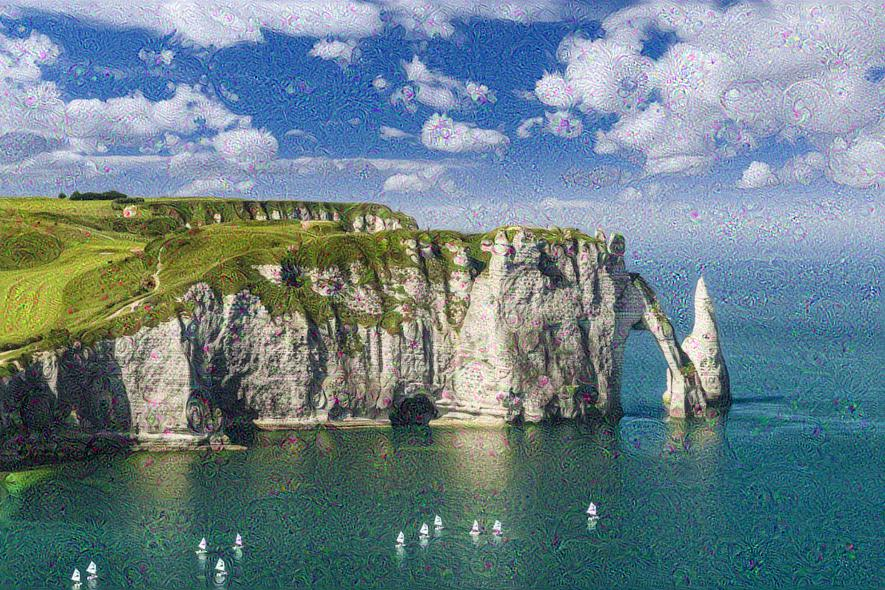

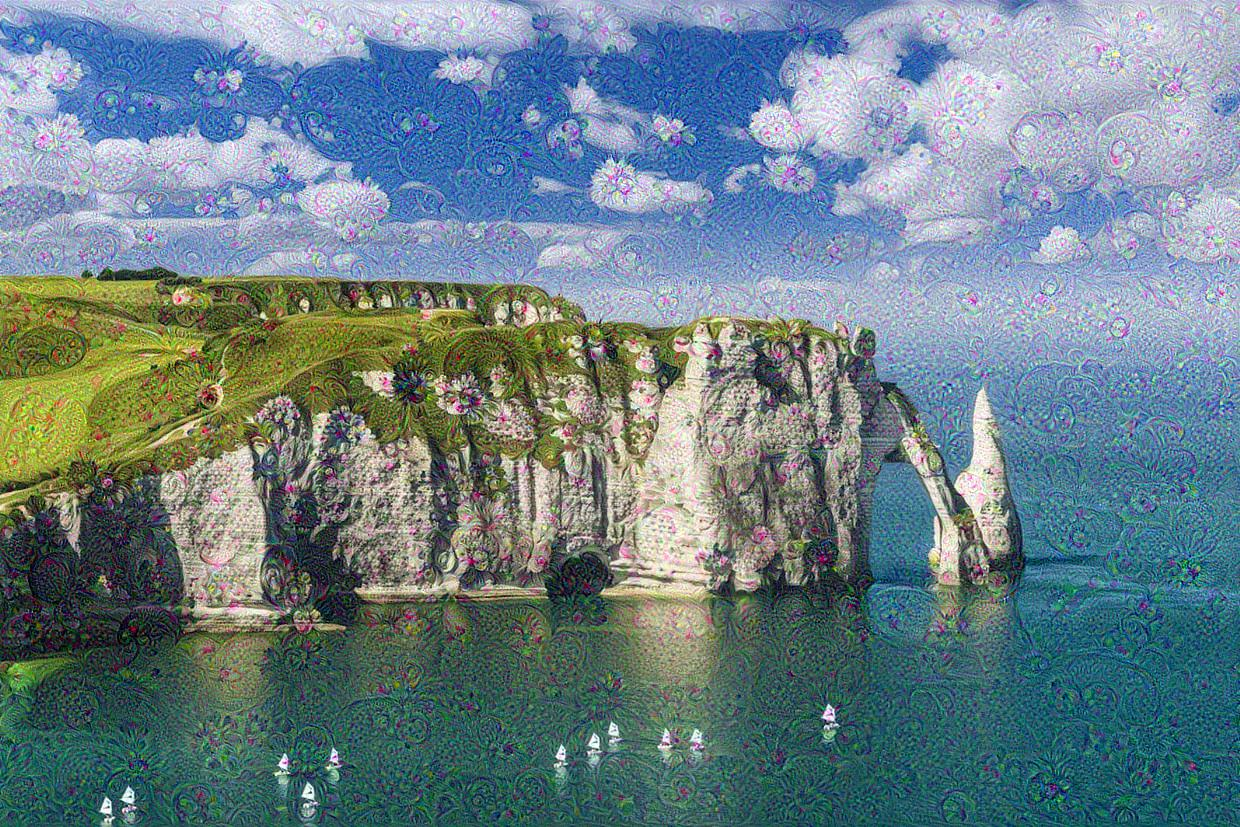

In [80]:
main()